### 1) Setup

In [1]:
# 1) Setup
import sys, os
sys.path.append("..")
from metalogic.runtime import PRJ, INP as INP_CFG, OUT, USE_VISION, summary
from pathlib import Path
summary()

# wejście z GCS (mount gcsfuse)
INP = Path.home() / "gcs/nonprl-ml/inputs"
OUT_DIR = OUT / "single"; OUT_DIR.mkdir(parents=True, exist_ok=True)

# klucz Vision
os.environ.setdefault("GOOGLE_APPLICATION_CREDENTIALS", str(Path.home()/ "secrets/vision-key.json"))

Project root: /home/wysokozaawansowany_gmail_com/work/MetaLogic
Inputs:       /home/wysokozaawansowany_gmail_com/work/MetaLogic/inputs
Outputs:      /home/wysokozaawansowany_gmail_com/work/MetaLogic/outputs
Bucket:       nonprl-ml
USE_VISION:   False


'/home/wysokozaawansowany_gmail_com/secrets/vision-key.json'

In [2]:
# 1b) Włącz Vision i sprawdź klucz
import os, json
from pathlib import Path

USE_VISION = True  # nadpisz flagę z runtime
KEY = Path.home() / "secrets" / "vision-key.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(KEY)

print("USE_VISION:", USE_VISION)
print("KEY exists:", KEY.exists(), "→", KEY)
if KEY.exists():
    try:
        print("project_id:", json.load(open(KEY))["project_id"])
    except Exception as e:
        print("key parse error:", e)

USE_VISION: True
KEY exists: True → /home/wysokozaawansowany_gmail_com/secrets/vision-key.json
project_id: pl-transcript-demo


### 2 Wybór pliku z dropdownem + miniatura

In [ ]:
# 2) Dropdown + miniatura
import ipywidgets as widgets
from IPython.display import display, Image as IPImage
from PIL import Image

files = sorted([p.name for p in INP.glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])
assert files, f"Brak obrazów w {INP}"

dropdown = widgets.Dropdown(options=files, description="Wybierz plik:", style={"description_width":"initial"}, layout=widgets.Layout(width="50%"))
display(dropdown)
thumb = widgets.Output(); display(thumb)

def show_thumbnail(p):
    with thumb:
        thumb.clear_output(wait=True)
        im = Image.open(p); im.thumbnail((220, 220))
        display(IPImage(im._repr_png_()))

def on_select(change):
    global IMG_PATH
    IMG_PATH = INP / change["new"]
    show_thumbnail(IMG_PATH)

IMG_PATH = INP / files[0]
show_thumbnail(IMG_PATH)
dropdown.observe(on_select, names="value")

Dropdown(description='Wybierz plik:', layout=Layout(width='50%'), options=('0004.jpg', '0006.jpg', '0009.jpg',…

Output()

### 3) Diagnostyka + uruchomienie Vision + zliczenia

In [11]:
# 3) Vision Enhanced: wszystkie dostępne detekcje
from google.cloud import vision
from pathlib import Path
from PIL import Image, ImageEnhance
import io, os

print("IMG_PATH:", IMG_PATH)
print("USE_VISION:", USE_VISION)
print("GAC exists:", Path(os.environ["GOOGLE_APPLICATION_CREDENTIALS"]).exists(), "→", os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

label_tags, object_tags, texts, logo_tags, boxes_vis = [], [], [], [], []

if USE_VISION:
    # --- Pre-enhance obrazu (kontrast / ostrość) ---
    img = Image.open(IMG_PATH).convert("RGB")
    img = ImageEnhance.Contrast(img).enhance(1.4)
    img = ImageEnhance.Sharpness(img).enhance(1.2)

    # zapis do bufora w pamięci
    buf = io.BytesIO()
    img.save(buf, format="JPEG", quality=95)
    buf.seek(0)
    gimg = vision.Image(content=buf.read())

    client = vision.ImageAnnotatorClient()
    LABEL_THR, OBJ_THR, LOGO_THR = 0.55, 0.55, 0.45

    # --- Label detection ---
    labels = client.label_detection(image=gimg).label_annotations
    label_tags = [l.description.lower() for l in labels if (l.score or 0) >= LABEL_THR]

    # --- Object detection ---
    objects = client.object_localization(image=gimg).localized_object_annotations
    object_tags = [o.name.lower() for o in objects if (o.score or 0) >= OBJ_THR]
    boxes_vis = [
        (o.name.lower(), [(v.x, v.y) for v in o.bounding_poly.normalized_vertices])
        for o in objects if (o.score or 0) >= OBJ_THR
    ]

    # --- Text detection (krótkie napisy) ---
    text_ann = client.text_detection(image=gimg).text_annotations
    if text_ann:
        for t in text_ann[1:]:
            s = t.description.strip().lower()
            if len(s) >= 3 and any(ch.isalpha() for ch in s):
                texts.append(s)

    # --- Document text detection (grupowane bloki) ---
    doc_ann = client.document_text_detection(image=gimg).full_text_annotation
    if doc_ann and doc_ann.text:
        blocks = [b.text.strip().lower() for b in doc_ann.pages[0].blocks if hasattr(b, "text")]
        for b in blocks:
            if len(b) >= 3:
                texts.append(b)

    # --- Logo detection ---
    logos = client.logo_detection(image=gimg).logo_annotations
    logo_tags = [l.description.lower() for l in logos if (l.score or 0) >= LOGO_THR]

    # --- Image properties ---
    props = client.image_properties(image=gimg).image_properties_annotation
    if props and props.dominant_colors.colors:
        dominant = [c.color for c in props.dominant_colors.colors[:3]]
        avg_color = tuple(int(sum(c[i].red for c in props.dominant_colors.colors)/len(props.dominant_colors.colors)) for i in range(3))
        print("dominant colors:", dominant[:3])
else:
    print("Vision pominięty.")

print(f"\nvision: {len(label_tags)} labels; {len(object_tags)} objects; {len(texts)} texts; {len(logo_tags)} logos")

IMG_PATH: /home/wysokozaawansowany_gmail_com/gcs/nonprl-ml/inputs/0241.jpg
USE_VISION: True
GAC exists: True → /home/wysokozaawansowany_gmail_com/secrets/vision-key.json


TypeError: 'ColorInfo' object is not subscriptable

### 4) Jednolity tekstowy output: wszystko razem


=== GOOGLE VISION SUMMARY ===

LABELS (6):
 • black and white
 • communication device
 • monochrome
 • office equipment
 • telephone
 • telephony

OBJECTS (3):
 • footwear
 • person
 • shoe

TEXTS (23):
 • archiwum
 • brama
 • crodek
 • dla
 • grodzka
 • jacka
 • lublinie
 • ludu
 • mes
 • mirosława
 • nagrody
 • najlepszy
 • oezo
 • plebiscitu
 • pmrn
 • rzeczowe
 • sklep
 • stoisko
 • swe
 • sztandaru
 • teatr
 • uczestników
 • zwycięzcow

LOGOS (0):

preview: /home/wysokozaawansowany_gmail_com/work/MetaLogic/outputs/single/preview_full_0241.jpg


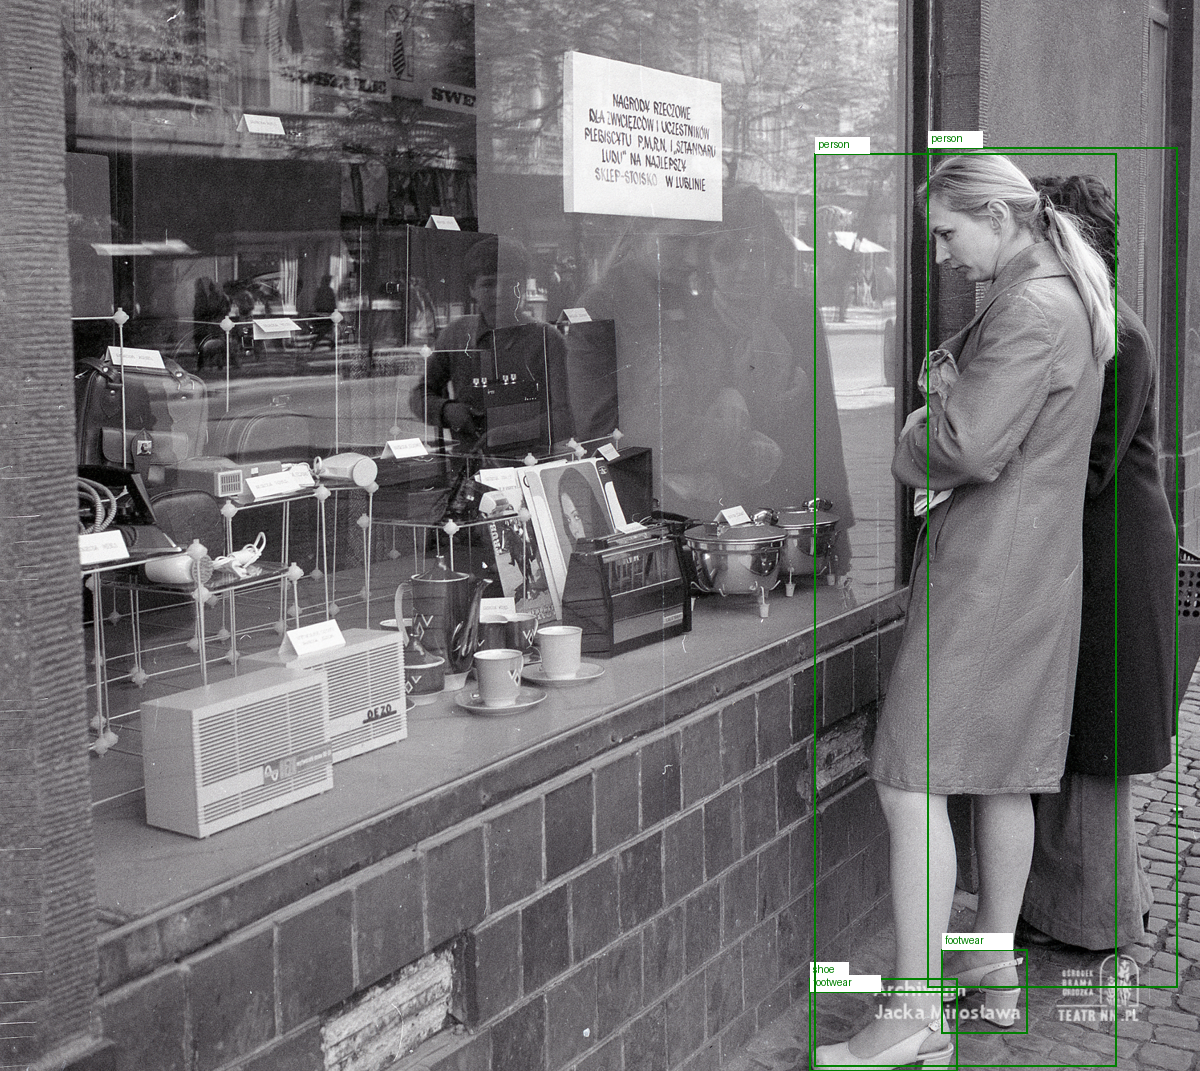

In [10]:
# 4+5) Pełny podgląd: tekstowy + miniatura z boxami
from pathlib import Path
from PIL import Image, ImageDraw
from IPython.display import display

# --- funkcja pomocnicza ---
def pretty(title, seq):
    ss = sorted(set(seq))
    print(f"\n{title} ({len(ss)}):")
    for s in ss: 
        print(" •", s)

# --- tekstowy raport ---
print("=== GOOGLE VISION SUMMARY ===")
pretty("LABELS",  label_tags)
pretty("OBJECTS", object_tags)
pretty("TEXTS",   texts)
pretty("LOGOS",   logo_tags)

# OCR grupy tekstu (szyldy)
if 'ocr_groups' in globals() and ocr_groups:
    print("\n=== OCR GROUPS (posortowane: szyldy najpierw) ===")
    for i, g in enumerate(ocr_groups, 1):
        tag = "[SIGN]" if g["is_sign"] else "      "
        txt = g["text"].replace("\n", " ").strip()
        print(f"{i:02d}. {tag} {txt[:140]}")

# --- grafika: boxy Vision + OCR ---
OUT_DIR = OUT / "single" if 'OUT' in globals() else Path.home()/ "work/MetaLogic/outputs/single"
OUT_DIR.mkdir(parents=True, exist_ok=True)

img = Image.open(IMG_PATH).convert("RGB")
W, H = img.size
scale = min(1200/W, 1200/H, 1.0)
nw, nh = int(W*scale), int(H*scale)
res = img.resize((nw, nh))
draw = ImageDraw.Draw(res)

# Boxy obiektów (zielone)
for name, verts in (boxes_vis or []):
    pts = [(int(x*nw), int(y*nh)) for (x,y) in verts]
    if len(pts) >= 2:
        draw.line(pts + [pts[0]], width=2, fill=(0, 128, 0))
        x0, y0 = pts[0]
        lbl = name
        draw.rectangle([x0, y0-16, x0+8*len(lbl)+6, y0], fill=(255,255,255))
        draw.text((x0+3, y0-15), lbl, fill=(0,128,0))

# Boxy OCR (ciemniejsze dla szyldów)
for g in (ocr_groups if 'ocr_groups' in globals() else []):
    verts = [(int(x*nw), int(y*nh)) for (x, y) in g["norm_box"]]
    color = (0,200,0) if not g["is_sign"] else (0,120,0)
    width = 2 if not g["is_sign"] else 4
    draw.line(verts + [verts[0]], width=width, fill=color)

# zapis i podgląd
out_img = OUT_DIR / f"preview_full_{IMG_PATH.stem}.jpg"
res.save(out_img)
print("\npreview:", out_img)
display(res)

### 5) Miniatura z boxami obiektów i OCR

In [ ]:
# 5) Miniatura z boxami obiektów i OCR
from PIL import Image, ImageDraw
from IPython.display import display

img = Image.open(IMG_PATH).convert("RGB")
W,H = img.size
scale = min(1200/W, 1200/H, 1.0)
nw, nh = int(W*scale), int(H*scale)
res = img.resize((nw,nh))
draw = ImageDraw.Draw(res)

# Vision objects
for name, verts in boxes_vis:
    pts = [(int(x*nw), int(y*nh)) for (x,y) in verts]
    if len(pts)>=2:
        draw.line(pts+[pts[0]], width=2)
        x0,y0 = pts[0]; y1 = max(y0-16,0)
        label = name
        draw.rectangle([x0,y1,x0+8*len(label)+6,y0], fill=(255,255,255))
        draw.text((x0+3,y1+1), label, fill=(0,128,0))

# OCR blocks
for g in ocr_groups:
    verts = [(int(x*nw), int(y*nh)) for (x,y) in g["norm_box"]]
    if len(verts)>=2:
        color = (0,200,0) if not g["is_sign"] else (0,120,0)
        width = 2 if not g["is_sign"] else 4
        draw.line(verts+[verts[0]], width=width, fill=color)

out_img = OUT_DIR / "preview_all.jpg"
res.save(out_img)
print("preview:", out_img)
display(res)

OCR groups: 9  |  signs: 0



Teksty zgrupowane:
01.        NAGRODY RZECZOWE DLA ZWYCIĘZCOW I UCZESTNIKÓW PLEBISCITU PMRN . I SZTANDARU LUDU " NA NAJLEPSZY SKLEP - STOISKO W LUBLINIE
02.        Archiwum Jacka Mirosława
03.        TEATR NN PL
04.        SWE
05.        OEZO
06.        BRAMA
07.        GRODZKA
08.        A MES
09.        CRODEK
preview: /home/wysokozaawansowany_gmail_com/work/MetaLogic/outputs/single/ocr_preview.jpg


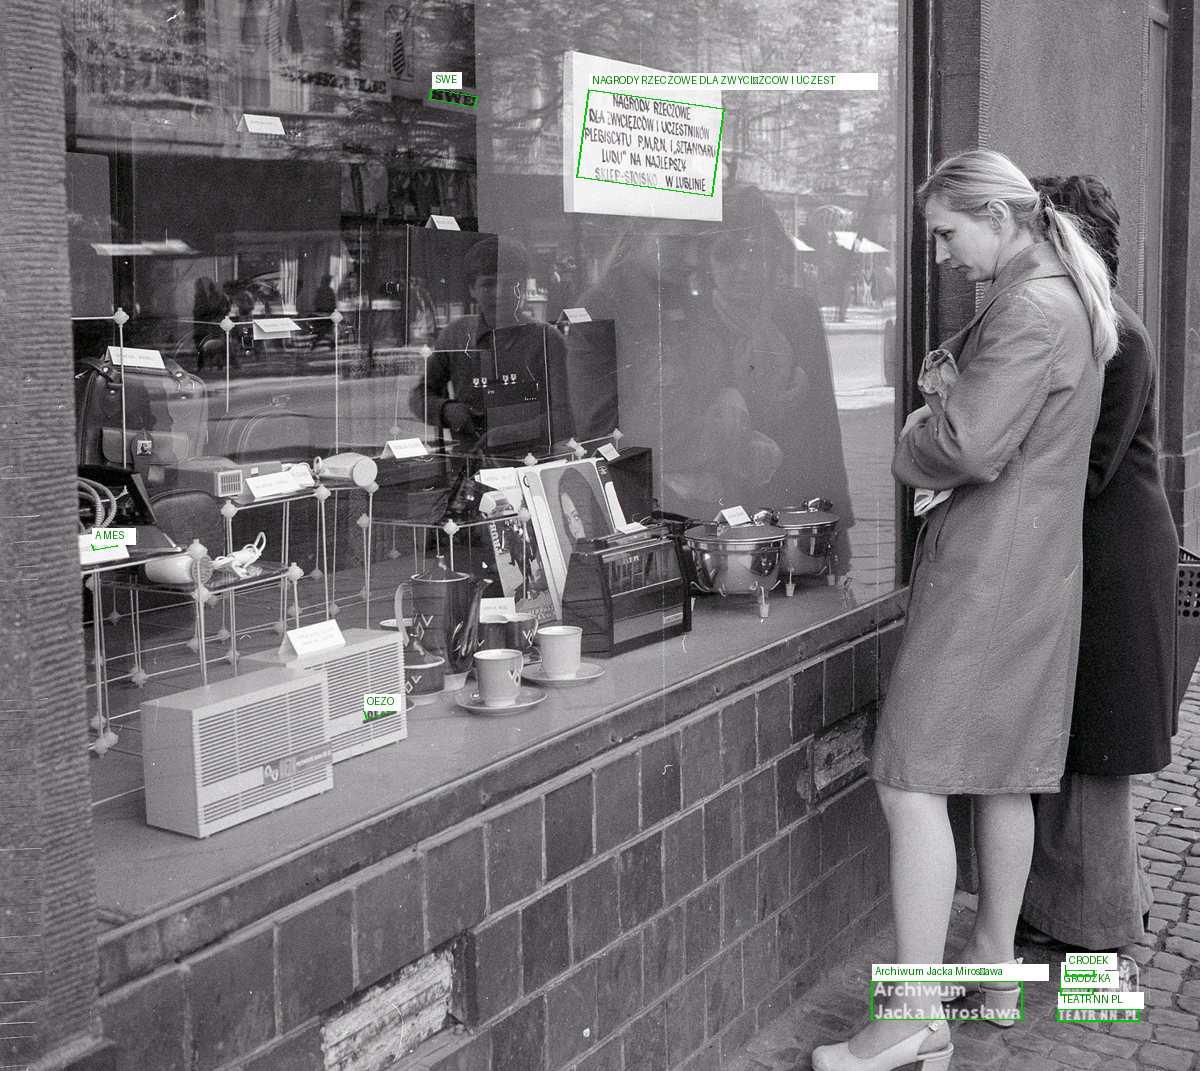

In [ ]:
### 5) Podgląd z boxami (obiekty + OCR)
# --- Prezentacja OCR: listowanie grup + miniatura z boxami ---
from PIL import Image, ImageDraw
from IPython.display import display

def pretty_groups(groups, k=None):
    print("\nTeksty zgrupowane:")
    for i, g in enumerate(groups[:(k or len(groups))], 1):
        tag = "[SIGN]" if g["is_sign"] else "      "
        txt = g["text"].strip().replace("\n"," ")
        print(f"{i:02d}. {tag} {txt}")

pretty_groups(ocr_groups)

img = Image.open(IMG_PATH).convert("RGB")
W, H = img.size
max_side = 1200
scale = min(max_side / W, max_side / H, 1.0)
nw, nh = int(W * scale), int(H * scale)
res = img.resize((nw, nh))
draw = ImageDraw.Draw(res)

# Rysuj: zielone zwykłe, grube i z tłem dla SIGN
for g in ocr_groups:
    verts = [(int(x * nw), int(y * nh)) for (x, y) in g["norm_box"]]
    if len(verts) >= 2:
        color = (0, 200, 0) if not g["is_sign"] else (0, 120, 0)
        width = 2 if not g["is_sign"] else 4
        draw.line(verts + [verts[0]], width=width, fill=color)

        # etykieta na górnej krawędzi
        x0, y0 = verts[0]
        label = ("SIGN: " if g["is_sign"] else "") + g["text"][:40]
        box_w = 7 * len(label) + 8
        y1 = max(y0 - 16, 0)
        draw.rectangle([x0, y1, x0 + box_w, y0], fill=(255, 255, 255))
        draw.text((x0 + 3, y1 + 1), label, fill=(0, 128, 0))

out_img = (OUT / "single") / "ocr_preview.jpg" if 'OUT' in globals() else Path.home()/ "work/MetaLogic/outputs/single/ocr_preview.jpg"
Path(out_img).parent.mkdir(parents=True, exist_ok=True)
res.save(out_img)
print("preview:", out_img)
display(res)

### 4) Scena z labels (Vision)

In [37]:
scene_top = []
if label_tags:
    scene_map = {
        "public event":  ["crowd","festival","parade","audience","event","concert","performance"],
        "old city street":["street","alley","historic site","town","architecture","building","cobblestone"],
        "factory/workshop":["factory","manufacturing","workshop","industrial","assembly line"],
        "shop/storefront":["storefront","shop","retail","market","supermarket"],
        "park/outdoors": ["park","trees","grass","recreation","outdoor"],
        "transport hub": ["station","platform","bus","tram","railway","terminal"],
    }
    ls = set(label_tags)
    scores = sorted(((k, sum(w in ls for w in v)) for k,v in scene_map.items()), key=lambda x:-x[1])
    scene_top = [s for s in scores if s[1]>0][:3]
scene_top

[]

### 6) Eksport CSV (Dublin Core)

In [ ]:
import pandas as pd

# Zbierz unikalne tagi z wszystkich źródeł
tags = sorted(set(label_tags + object_tags + texts + logo_tags))

# Utwórz strukturę CSV zgodną z dLibra
rows = [
    ("", "pl", "en", "universal"),
    ("Title", "Ulica z szyldami", "Street photo with shop signs", ""),
    ("Description", "Widok ulicy z ludźmi i szyldami.", "Street view with people and text signs.", "")
]

# Dodaj wszystkie tagi jako Subject
for t in tags:
    rows.append(("Subject", "", t, ""))

# Dodaj scenę (jeśli istnieje)
if "scene_top" in locals() and scene_top:
    for scene, _ in scene_top:
        rows.append(("Subject", "", scene, ""))

# Zapisz CSV
out_csv = OUT_DIR / "import_dlibra.csv"
pd.DataFrame(rows).to_csv(out_csv, index=False, header=False, encoding="utf-8")

print("csv:", out_csv)